# Softmax Function

The softmax function (also known as softargmax or normalized exponential function) converts a vector of $K$ real numbers into a probability distribution of $K$ possible outcomes. It is a generalization of the logistic function to multiple dimensions, and used in multinomial logistic regression (Softmax Regression) and in Neural Networks when solving Multiclass Classification problems.

<center>  <img  src="images/C2_W2_Softmax_Header.PNG" width="1100" />  </center>

Each of the $j \in 1 ,..., N$ linear predictors

$$z_{j}=\vec{w}_{j}\vec{x}+b_{j}$$

is a binary classification problem where the linear predictor $z_{j}$ is mapped to a probability via the softmax function

$$a_j=\frac{e^{z_j}}{\sum_{k=1}^{N} e^{z_k}}=\mathrm{P}(\mathrm{y}=j \mid \overrightarrow{\mathrm{x}})$$

and $\mathrm{P}(\mathrm{y}=j \mid \overrightarrow{\mathrm{x}})$ indicates the probability that the output is class $j$.


**Note**: We start counts with 0 and ending with N-1,  $\sum_{i=0}^{N-1}$ and not 1 and end with N,  $\sum_{i=1}^{N}$. This is because computer programs will typically start iterating with 0 but mathematically we usually index from 1 to N.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('utils/deeplearning.mplstyle')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from IPython.display import display, Markdown, Latex
from sklearn.datasets import make_blobs

from matplotlib.widgets import Slider
from utils.lab_utils_common import dlc
from utils.lab_utils_softmax import plt_softmax
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

## Softmax Function
In both softmax regression and neural networks with Softmax outputs, N outputs are generated and one output is selected as the predicted category. In both cases a vector $\mathbf{z}$ is generated by a linear function which is applied to a softmax function. The softmax function converts $\mathbf{z}$  into a probability distribution as described below. After applying softmax, each output will be between 0 and 1 and the outputs will add to 1, so that they can be interpreted as probabilities. The larger inputs  will correspond to larger output probabilities.

<center>  <img  src="images/C2_W2_SoftmaxReg_NN.png" width="800" />  </center>

The softmax function can be written:
\begin{align*}
a_j = \frac{e^{z_j}}{ \sum_{k=1}^{N}{e^{z_k} }}
\end{align*}

The output $\vec{a}$ is a vector of length N, so for softmax regression, we could also write:
\begin{align*}
\vec{a}(x) =
\begin{bmatrix}
P(y = 1 | \mathbf{x}; \mathbf{w},b) \\
\vdots \\
P(y = N | \mathbf{x}; \mathbf{w},b)
\end{bmatrix}=\frac{1}{\sum_{k=1}^{N}{e^{z_k} }}
\begin{bmatrix}
e^{z_1} \\
\vdots \\
e^{z_{N}} \\
\end{bmatrix}
\end{align*}

This shows that the output is a **vector of probabilities**. The first entry is the probability the output is the first category given the input $\mathbf{x}$ and parameters $\mathbf{w}$ and $\mathbf{b}$. Let's create a NumPy implementation:


In [3]:
def my_softmax(z: np.ndarray) -> np.ndarray:
    """
    Softmax function.

    Parameters
    ----------
    z : np.ndarray
        A vector of linear predictors.

    Returns
    -------
    np.ndarray
        A vector of probabilities.
    """
    ez = np.exp(z)              # Element-wise exponentiation
    sm = ez / np.sum(ez)
    return sm

Below, vary the values of the `z` inputs using the sliders.

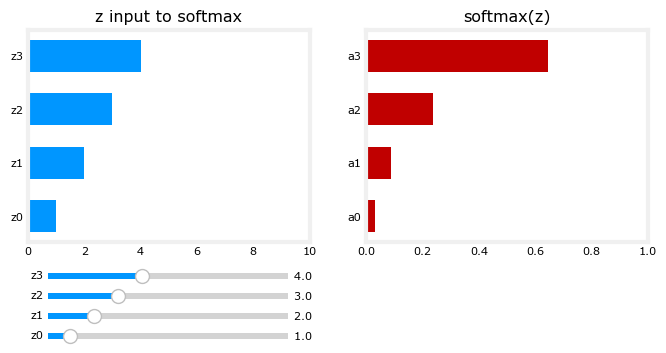

In [4]:
plt.close("all")
plt_softmax(my_softmax)

As we vary the values of the linear predictors z's above, there are a few things to note:
* the exponential in the numerator of the softmax magnifies small differences in the values 
* the output values sum to one
* the softmax spans all of the outputs. A change in `z0` for example will change the values of `a0`-`a3`. Compare this to other activations such as ReLU or Sigmoid which have a single input and single output.

## Cost
<center> <img  src="images/C2_W2_SoftMaxCost.png" width="700" />    </center>

The loss function associated with Softmax, the cross-entropy loss, is:
\begin{equation}
  L(\vec{a},y)=\begin{cases}
    -log(a_1), & \text{if $y=1$}.\\
        &\vdots\\
     -log(a_N), & \text{if $y=N$}
  \end{cases} \tag{3}
\end{equation}

Where y is the target category for this example (a row in the data matrix) and $\vec{a}$ is the output of a softmax function. In particular, the values in $\vec{a}$ are probabilities that sum to one.

>**Recall:** Loss is defined for one training example (a row or one observation) while Cost covers all training examples. 
 
 
Note in (3) above, only the line that corresponds to the target contributes to the loss, other lines are zero. To write the cost equation we need an 'indicator function' that will be 1 when the index matches the target and zero otherwise. 
    $$\mathbf{1}\{y == n\} = =\begin{cases}
    1, & \text{if $y==n$}.\\
    0, & \text{otherwise}.
  \end{cases}$$
Now the cost is:
\begin{align}
J(\mathbf{w},b) = -\frac{1}{m} \left[ \sum_{i=1}^{m} \sum_{j=1}^{N}  1\left\{y^{(i)} == j\right\} \log \frac{e^{z^{(i)}_j}}{\sum_{k=1}^N e^{z^{(i)}_k} }\right] \tag{4}
\end{align}

Where $m$ is the number of examples, $N$ is the number of outputs. This is the average of all the losses.


## Tensorflow

There are two ways of implementing the softmax using the cross-entropy loss in Tensorflow; the first is the most straightforward while the second is more numerically stable. Let's start by creating a dataset to train a multiclass classification model.

In [5]:
# Make  dataset for example
centers = [[-5, 2], [-2, -2], [1, 2], [5, -2]]
X_train, y_train = make_blobs(n_samples=2000, centers=centers, cluster_std=1.0,random_state=30)

In [6]:
X_train.shape, y_train.shape

((2000, 2), (2000,))

The data set contains two features (columns). It has the following four classes in its labels:

In [7]:
np.unique(y_train)

array([0, 1, 2, 3])

### The Straightforward Organization

The model below is implemented with the softmax as an activation function in the final output or dense layer. The loss function is separately specified in the `compile` directive. 

The loss function is `SparseCategoricalCrossentropy`, which is described in (3) above. In this model, the softmax takes place in the last layer. The loss function takes in the softmax output, which is a vector of probabilities $\vec{a}=\begin{bmatrix}a_{1} \\ \vdots \\ a_{N}\end{bmatrix}$. Note that the hidden layers use `relu` as activation functions. 

In [8]:
model = Sequential(
    [ 
        Dense(25, activation = 'relu'),
        Dense(15, activation = 'relu'),
        Dense(4, activation = 'softmax')    # < Softmax activation
    ]
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

model.fit(
    X_train,
    y_train,
    epochs=10 # The entire dataset is passed forward in the network 10 times
)
        

Epoch 1/10
63/63 [==============================] - 1s 2ms/step - loss: 0.9594
Epoch 2/10
63/63 [==============================] - 0s 1ms/step - loss: 0.3464
Epoch 3/10
63/63 [==============================] - 0s 1ms/step - loss: 0.1586
Epoch 4/10
63/63 [==============================] - 0s 1ms/step - loss: 0.1005
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0765
Epoch 6/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0636
Epoch 7/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0556
Epoch 8/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0502
Epoch 9/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0459
Epoch 10/10
63/63 [==============================] - 0s 1ms/step - loss: 0.0427


Because the softmax is integrated into the output layer, the output is a vector of probabilities.

In [9]:
p_nonpreferred = model.predict(X_train)
print('The shape of the output is', p_nonpreferred.shape)

63/63 [==============================] - 0s 778us/step
The shape of the output is (2000, 4)


For each of the 2000 training example (sample or row), there are four probabilities corresponding to the four classes: 

In [10]:
p_nonpreferred

array([[5.66e-03, 2.07e-03, 9.75e-01, 1.68e-02],
       [9.90e-01, 1.03e-02, 4.77e-05, 6.81e-05],
       [9.48e-01, 5.07e-02, 5.23e-04, 6.60e-04],
       ...,
       [2.33e-03, 9.92e-01, 1.71e-03, 3.69e-03],
       [9.80e-05, 1.04e-04, 5.39e-04, 9.99e-01],
       [9.06e-03, 1.76e-03, 9.85e-01, 4.04e-03]], dtype=float32)

In [11]:
print("largest value", np.max(p_nonpreferred), "smallest value", np.min(p_nonpreferred))

largest value 0.99999636 smallest value 1.561581e-08


### Preferred Organization


<center> <img  src="images/C2_W2_softmax_accurate.png" width="700" />    </center>

The more stable and accurate results can be obtained if the **softmax and loss are combined during training**. This is enabled by the 'preferred' organization shown below.

In the preferred organization, the final layer has a linear activation (or no activation). For historical reasons, the outputs in this form are referred to as *logits*. The loss function has an additional argument: `from_logits = True`. This informs the loss function that the softmax operation should be included in the loss calculation as supposed to using the probabilities values in the vector $\vec{a}$. This allows for an optimized implementation.


In [12]:
preferred_model = Sequential(
    [ 
        Dense(25, activation = 'relu'),
        Dense(15, activation = 'relu'),
        Dense(4, activation = 'linear')   # Use linear activation
    ]
)
preferred_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Set from_logits=True
    optimizer=tf.keras.optimizers.Adam(0.001),
)

preferred_model.fit(
    X_train,y_train,
    epochs=10
)
        

Epoch 1/10
63/63 [==============================] - 1s 1ms/step - loss: 1.0442
Epoch 2/10
63/63 [==============================] - 0s 1ms/step - loss: 0.4408
Epoch 3/10
63/63 [==============================] - 0s 1ms/step - loss: 0.2062
Epoch 4/10
63/63 [==============================] - 0s 3ms/step - loss: 0.1173
Epoch 5/10
63/63 [==============================] - 0s 3ms/step - loss: 0.0831
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0666
Epoch 7/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0572
Epoch 8/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0510
Epoch 9/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0463
Epoch 10/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0426


#### Output Handling
Notice that in the preferred model, the outputs are not probabilities, but can range from large negative numbers to large positive numbers. The output must be sent through a softmax when performing a prediction that expects a probability. 
Let's look at the preferred model outputs:

In [13]:
p_preferred = preferred_model.predict(X_train)
p_preferred

63/63 [==============================] - 0s 993us/step


array([[-3.01, -2.69,  1.65, -1.84],
       [ 5.84, -0.68, -4.69, -8.77],
       [ 3.98, -0.26, -3.51, -6.87],
       ...,
       [-4.9 ,  3.24, -2.39, -1.95],
       [-4.98, -2.47, -4.67,  4.34],
       [-2.49, -2.23,  2.68, -2.89]], dtype=float32)

In [14]:
print("largest value", np.max(p_preferred), "smallest value", np.min(p_preferred))

largest value 9.3184185 smallest value -17.259165


The output predictions are not probabilities!
If the desired output are probabilities, then the output should be be processed by a [softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax).

In [15]:
sm_preferred = tf.nn.softmax(p_preferred).numpy()
sm_preferred

array([[8.99e-03, 1.25e-02, 9.49e-01, 2.91e-02],
       [9.98e-01, 1.47e-03, 2.65e-05, 4.50e-07],
       [9.85e-01, 1.42e-02, 5.51e-04, 1.90e-05],
       ...,
       [2.87e-04, 9.91e-01, 3.53e-03, 5.53e-03],
       [8.96e-05, 1.10e-03, 1.22e-04, 9.99e-01],
       [5.63e-03, 7.28e-03, 9.83e-01, 3.77e-03]], dtype=float32)

In [16]:
print("largest value", np.max(sm_preferred), "smallest value", np.min(sm_preferred))

largest value 0.9999966 smallest value 9.179213e-12


To select the most likely category, the softmax is not required. One can find the index of the largest output using [np.argmax()](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html).

In [17]:
for i in range(20):
    # Note that p_preferred[i] is a 1D array of length 4 (4,) so argmax finds the index of the largest value over the 1st axis 0
    print( f"{p_preferred[i]}, The NN predicts category: {np.argmax(p_preferred[i], axis=0)}")

[-3.01 -2.69  1.65 -1.84], The NN predicts category: 2
[ 5.84 -0.68 -4.69 -8.77], The NN predicts category: 0
[ 3.98 -0.26 -3.51 -6.87], The NN predicts category: 0
[-4.12  3.53 -1.86 -2.55], The NN predicts category: 1
[-2.05 -3.41  3.59 -6.18], The NN predicts category: 2
[-3.5  -3.2   2.77 -3.05], The NN predicts category: 2
[-5.47  3.74 -2.71 -2.22], The NN predicts category: 1
[  7.02  -1.87  -4.94 -11.49], The NN predicts category: 0
[-4.53  4.   -2.09 -2.85], The NN predicts category: 1
[-4.48 -2.53 -3.35  3.15], The NN predicts category: 3
[-2.82  1.5  -1.19 -1.06], The NN predicts category: 1
[-4.34 -4.    3.45 -3.88], The NN predicts category: 2
[  5.09  -3.06  -2.01 -12.16], The NN predicts category: 0
[-4.7  -4.6   4.75 -5.4 ], The NN predicts category: 2
[-3.63 -3.3   2.19 -2.48], The NN predicts category: 2
[ 6.48 -1.17 -4.91 -9.69], The NN predicts category: 0
[-7.75  6.21 -3.93 -3.86], The NN predicts category: 1
[-2.19 -1.94  1.74 -1.78], The NN predicts category: 2
[-

## SparseCategorialCrossentropy or CategoricalCrossEntropy

Tensorflow has two potential formats for target values and the selection of the loss defines.

- `SparseCategorialCrossentropy` expects the target to be an integer corresponding to the index. For example, if there are 10 potential target values, y would be between 0 and 9. 
  
- `CategoricalCrossEntropy` expects the target value of an example to be one-hot encoded where the value at the target index is 1 while the other N-1 entries are zero. Each example or row of the data matrix has 10 potential target values (columns). For instance, if the $ith$ training example has target label class equaling 2, then `X_train[i]` would be [0,0,1,0,0,0,0,0,0,0].
